Exploring the US energy dataset and training an XGBoost model for time series predictions. Based on these tutorials: https://www.youtube.com/watch?v=z3ZnOW-S550&ab_channel=RobMulla and https://www.kaggle.com/code/robikscube/pt2-time-series-forecasting-with-xgboost/notebook 

## Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Set random seed for reproducibility
np.random.seed(42)

## Update style of plots

I like the clean style provided by ggplot and Cedric so I am using that similar style here

In [ ]:
plt.style.use('ggplot')
plt.rcParams.update({
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.0,
    'axes.titlesize': 12,
    'axes.titleweight': 'bold',
    'axes.titlepad': 10,
    'axes.labelcolor': 'black',
    'axes.labelsize': 12,
    'xtick.color': 'black',
    'ytick.color': 'black',
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'grid.color': 'white',
    'grid.linestyle': '',
    'legend.frameon': False,
    'legend.loc': 'lower center',
    'legend.title_fontsize': None,
    'legend.fontsize': 12,
    'figure.titlesize': 12,
    'figure.facecolor': 'white',
    'figure.edgecolor': 'white',
    'figure.autolayout': True,
    'axes.grid': False,
    'axes.facecolor': 'white',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.titlelocation': 'left',
    'axes.titley': 1.05,
    'axes.titlepad': 10,
    'axes.labelpad': 8,
    'figure.subplot.left': 0.15,
    'figure.subplot.right': 0.95,
    'figure.subplot.bottom': 0.15,
    'figure.subplot.top': 0.95,
})

# seaborn color palette
color_pal = sns.color_palette()

## Load data

,Residential,Commercial,Industrial,Transportation,Electric Power
Date,,,,,
1973-01-01,1339.270,657.977,2027.033,1504.805,1691.096
1973-02-01,1174.899,623.759,1841.299,1438.298,1511.458
1973-03-01,983.374,492.136,1926.411,1561.293,1559.159
1973-04-01,715.391,363.393,1914.017,1480.403,1470.152
1973-05-01,535.914,288.630,2076.468,1622.115,1551.631


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 564 entries, 1973-01-01 to 2019-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Residential  564 non-null    float64
dtypes: float64(1)
memory usage: 8.8 KB
None
       Residential
count   564.000000
mean    586.621222
std     321.290027
min     192.108000
25%     303.245750
50%     484.424000
75%     875.318500
max    1488.040000
Residential    0
dtype: int64


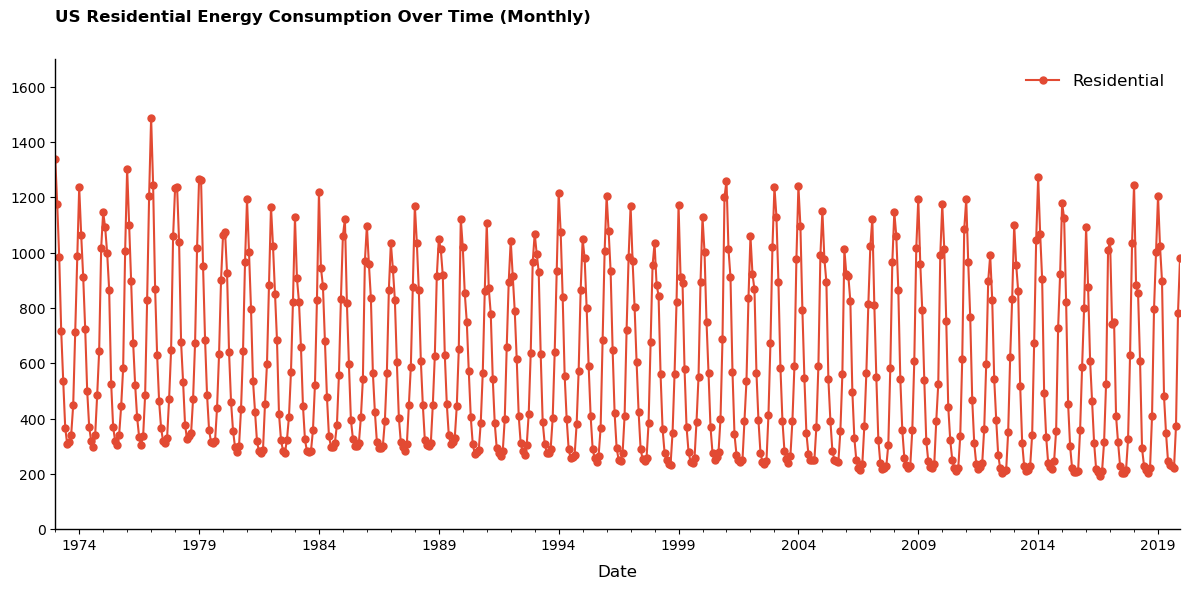

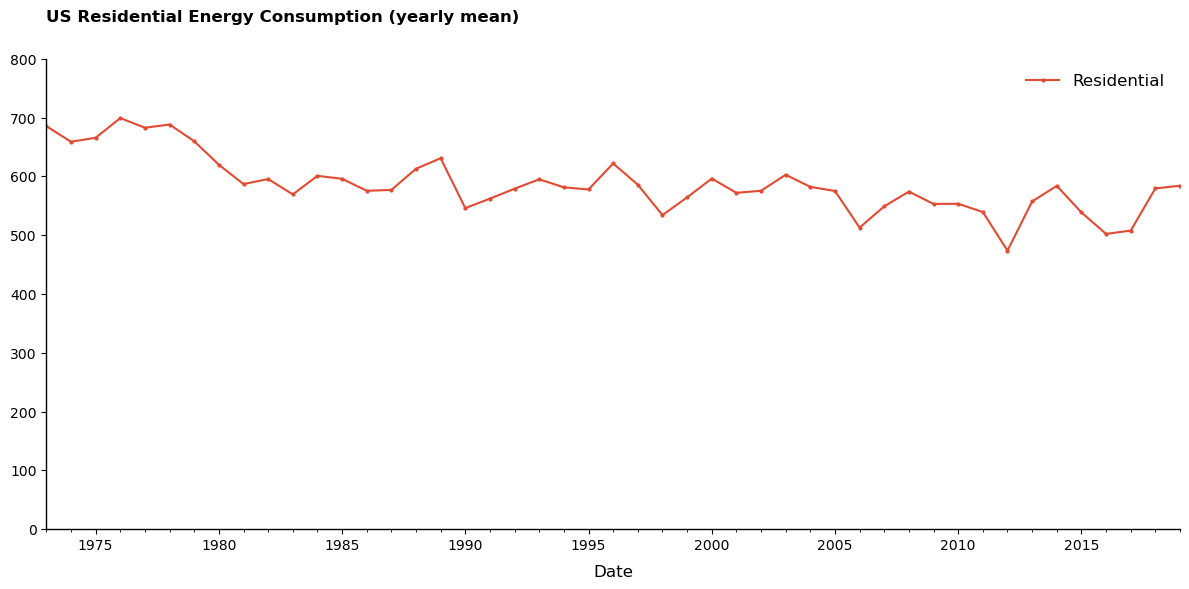

In [50]:
# Load in and parse the data
#data = pd.read_excel('C:/Users/Andrew/Documents/Learning coding notes/Time-series-analysis-of-US-energy-usage/data-raw/Energy_consumption_US_data.xlsx' , parse_dates=['Date'], index_col='Date')
df = pd.read_excel('../data-raw/Energy_consumption_US_data.xlsx' , parse_dates=['Date'], index_col='Date')

display(df.head())

# Lets just focus on residential energy consumption
df_residential = df[['Residential']]

# Check the data for missing values and basic statistics
print(df_residential.info())
print(df_residential.describe())
print(df_residential.isnull().sum())


# Visualize the data
df_residential.plot(
    linestyle='-', 
    marker='o', 
    markersize=5, 
    figsize=(12, 6), 
    color=color_pal[0],
    title='US Residential Energy Consumption Over Time (Monthly)'
)
plt.ylim(0, 1700)  # Set your desired min and max values here
plt.show()

# Resample to monthly frequency (use 'ME' for month-end)
df_resampled = df_residential.resample('YE').mean()

# Visualize the resampled data
df_resampled.plot(
    linestyle='-', 
    marker='o', 
    markersize=2, 
    figsize=(12, 6), 
    color=color_pal[0],
    title='US Residential Energy Consumption (yearly mean)'
)
plt.ylim(0, 800)  # Set your desired min and max values here
plt.show()



Plotting by month (first plot), we can see a real seasonal trend of downtrend for the first 6 months then increase for the next 6 months. 

The second plot shows the plot by year (not month) and it looks like there is a slight downward trend?

## Checking rolling mean

In [ ]:
# Calculate and plot the rolling yearly mean (12-month moving average)
df_residential['RollingYearlyMean'] = df_residential['Residential'].rolling(window=12).mean()

df_residential[['Residential', 'RollingYearlyMean']].plot(
    figsize=(12, 6),
    color=[color_pal[0], color_pal[1]],
    title='US Residential Energy Consumption with 12-Month Rolling Mean'
)
plt.ylim(0, 1700)  # Set your desired min and max values here
plt.show()

## Checking for outliers

I plot a histogram to see if there are any potential outliers and also to see the overall trends.
- You can see that there might be one potential outlieretween 1400 and 1600 which probably occured in 1977 (see chart above) but I dont think this is going to be a big issue
- You also see with the KDE two bumps indicating lots of values around 300 and 1000. This makes sense given the seasonal data (again see plots above) where the 300s are the throughs and 1000s are the highs

In [ ]:
df_residential['Residential'].plot(kind='hist', bins=200, color=color_pal[0], alpha=0.8)
plt.title('Distribution of Residential Energy Consumption')
plt.xlim(0, 1700)  # Adjust as needed to focus on the main range
plt.show()



ax = df_residential['Residential'].plot(kind='hist', bins=200, color=color_pal[0], alpha=0.8, density=True)
df_residential['Residential'].plot(kind='kde', color=color_pal[2], linewidth=2, ax=ax)
plt.title('Distribution of Residential Energy Consumption (KDE)')
plt.xlim(0, 1700)  # Adjust as needed to focus on the main range
plt.show()

# Feature engineering

We are going to perform some basic feature engineering to get data in shape

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index (day of the week, month etc...).
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

# Add lag features i.e. previous values of the target variable (i.e 1 year ago, 2 years ago, etc.)
# This is useful for time series forecasting models
def add_lags(df):
    # Add lag features for 1, 2, and 3 years ago (assuming monthly data, so 12, 24, 36 months)
    df['lag1'] = df['Residential'].shift(12)
    df['lag2'] = df['Residential'].shift(24)
    df['lag3'] = df['Residential'].shift(36)
    return df

df_residential = create_features(df_residential)
df_residential = add_lags(df_residential)

display(df_residential.tail(100))

,Residential,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Date,,,,,,,,,,,
2011-09-01,238.509,3,3,9,2011,244,1,35,219.797,235.905,229.987
2011-10-01,363.633,5,4,10,2011,274,1,39,336.526,391.531,358.251
2011-11-01,595.311,1,4,11,2011,305,1,44,614.540,525.295,607.267
2011-12-01,897.632,3,4,12,2011,335,1,48,1084.526,990.179,1016.781
2012-01-01,989.638,6,1,1,2012,1,1,52,1191.842,1173.864,1193.633
...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,229.221,3,3,8,2019,213,1,31,204.051,204.441,192.108
2019-09-01,220.762,6,3,9,2019,244,1,35,220.190,214.928,211.069
2019-10-01,373.179,1,4,10,2019,274,1,40,408.262,324.578,314.470


## Cross-validation and training

We will be training an xgboost model to predict data into the future. We will use the timeseriessplit (equivalent to cross-fold validation) to ensure no data leakage!

In [59]:
from sklearn.model_selection import TimeSeriesSplit

# Create time series cross-validator which splits the data into training and test sets based on time so no data leakage occurs.
# test_size = 12  # Number of months for the test set
# gap = 1  # 1 month gap between train and test sets
tss = TimeSeriesSplit(n_splits=5, test_size=12*1, gap=1)
df_residential = df_residential.sort_index()


fold = 0
preds = []
scores = []
# Split the data into training and validation sets using time series cross-validation and train the model on each fold.
for train_idx, val_idx in tss.split(df_residential):
    train = df_residential.iloc[train_idx]
    test = df_residential.iloc[val_idx]

    FEATURES = ['dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'Residential'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01,
                           random_state=42)  # Early stopping rounds will stop training if no improvement in 50 rounds in validation set
    
    
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)  # print evaluation every 100 iterations

    # Append predictions and scores (mean error) for each fold 
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

print(f'Mean error scores across folds: {np.mean(scores):0.4f}')
print(f'Fold mean error scores:{scores}')


[0]	validation_0-rmse:664.73703	validation_1-rmse:632.76259


[100]	validation_0-rmse:257.67422	validation_1-rmse:227.68565
[200]	validation_0-rmse:114.66762	validation_1-rmse:102.65518
[300]	validation_0-rmse:69.97508	validation_1-rmse:70.35806
[386]	validation_0-rmse:57.74951	validation_1-rmse:70.51908
[0]	validation_0-rmse:664.32240	validation_1-rmse:585.31739
[100]	validation_0-rmse:257.32932	validation_1-rmse:198.20073
[200]	validation_0-rmse:114.27366	validation_1-rmse:90.03324
[296]	validation_0-rmse:70.58215	validation_1-rmse:87.28585
[0]	validation_0-rmse:662.10266	validation_1-rmse:586.24623
[100]	validation_0-rmse:256.46512	validation_1-rmse:218.47428
[200]	validation_0-rmse:114.05604	validation_1-rmse:106.36031
[300]	validation_0-rmse:70.06063	validation_1-rmse:85.99547
[400]	validation_0-rmse:57.23177	validation_1-rmse:76.36611
[475]	validation_0-rmse:53.34265	validation_1-rmse:76.64681
[0]	validation_0-rmse:660.44498	validation_1-rmse:670.92382
[100]	validation_0-rmse:256.17312	validation_1-rmse:298.21945
[200]	validation_0-rmse:115

## LightGBM as an alternative to xgboost

Here, we are using lightGBM to see if there is any difference

In [ ]:
import lightgbm as lgb

# LightGBM cross-validation
lgb_preds = []
lgb_scores = []

for train_idx, val_idx in tss.split(df_residential):
    train = df_residential.iloc[train_idx]
    test = df_residential.iloc[val_idx]

    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]

    lgb_reg = lgb.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=3,
        random_state=42
    )

    lgb_reg.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        early_stopping_rounds=50,
        verbose=100
    )

    y_pred = lgb_reg.predict(X_test)
    lgb_preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    lgb_scores.append(score)

print(f'LightGBM mean error scores across folds: {np.mean(lgb_scores):0.4f}')
print(f'LightGBM fold mean error scores: {lgb_scores}')

## Predicting the future

We need to first train the model using ALL data and then we can predict into the future!

In [61]:
# Retrain on all data
X_all = df_residential[FEATURES]
y_all = df_residential[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01,
                       random_state=42)  # Early stopping rounds will stop training if no improvement in 50 rounds in validation set

reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)



[0]	validation_0-rmse:661.78176


[100]	validation_0-rmse:256.36600
[200]	validation_0-rmse:114.38110
[300]	validation_0-rmse:71.06747
[400]	validation_0-rmse:58.91855
[499]	validation_0-rmse:54.08432


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

Check the last date in our dataset then create a time series that goes beyond that so that we can then use that as input for our ML prediction

2019-12-01 00:00:00


,Residential,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2020-05-31,NaN,6,2,5,2020,152,31,22,347.198,291.885,313.419,True
2020-06-30,NaN,1,2,6,2020,182,30,27,246.071,227.954,229.599,True
2020-07-31,NaN,4,3,7,2020,213,31,31,230.598,213.982,202.606,True
2020-08-31,NaN,0,3,8,2020,244,31,36,229.221,204.051,204.441,True
2020-09-30,NaN,2,3,9,2020,274,30,40,220.762,220.190,214.928,True
2020-10-31,NaN,5,4,10,2020,305,31,44,373.179,408.262,324.578,True
2020-11-30,NaN,0,4,11,2020,335,30,49,781.616,797.162,627.865,True
2020-12-31,NaN,3,4,12,2020,366,31,53,979.352,1002.733,1035.339,True
2021-01-31,NaN,6,1,1,2021,31,31,4,NaN,1203.798,1244.596,True
2021-02-28,NaN,6,1,2,2021,59,28,8,NaN,1022.053,883.676,True


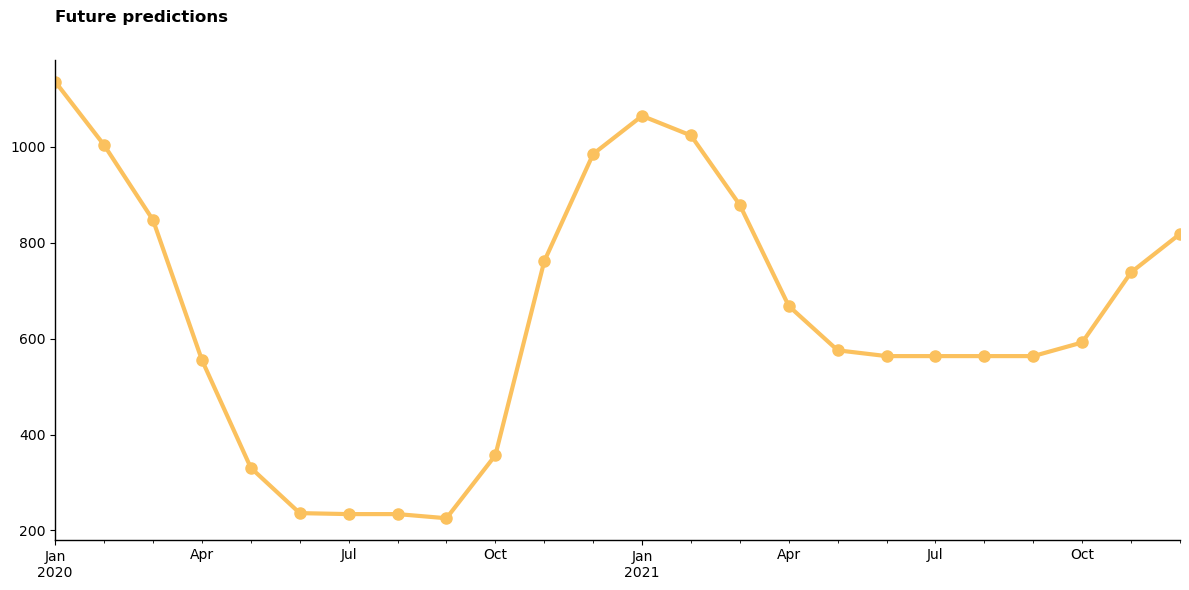

In [73]:
print(df_residential.index.max())

# Create future dataframe
future = pd.date_range('2020-01-01','2022-01-01', freq='1ME')   # Monthly frequency end of month
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df_residential['isFuture'] = False
df_and_future = pd.concat([df_residential, future_df])

# Create features and lags for the future dataframe
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

display(df_and_future.tail(20))

# Create predictions for the future dataframe
future_w_features = df_and_future.query('isFuture').copy()
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(
    linestyle='-', 
    color=color_pal[4],                              
    marker='o', 
    markersize=8,
    lw=3, 
    figsize=(12, 6), 
    title='Future predictions')

plt.show()

# Save model if needed
reg.save_model('model.json')

## Load saved model to perform predictions

In [ ]:
# reg_new = xgb.XGBRegressor()
# reg_new.load_model('model.json')
# future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
# future_w_features['pred'].plot(figsize=(10, 5),
#                                color=color_pal[4],
#                                ms=1, lw=1,
#                                title='Future Predictions')